### Loading Jupyter notification extension for Chrome

Please refer:
https://github.com/ShopRunner/jupyter-notify

In [11]:
%load_ext jupyternotify

%notify -m "loaded jupyternotify"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final Project

## Dependencies
* NLTK
* Tensorflow
* keras
* h5py
* Seaborn
* Sklearn
* matplotlib
* pandas
* numpy

In [1]:
import string, re, pickle
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
color = sns.color_palette()

from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler

## Preparing Dataset
### downloading dataset method 1

In [6]:
# download annotated comments and annotations
import requests

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

ANNOTATED_COMMENTS = requests.get(ANNOTATED_COMMENTS_URL, allow_redirects=True)
ANNOTATIONS = requests.get(ANNOTATIONS_URL, allow_redirects=True)

open('dataset/attack_annotated_comments.tsv', 'wb').write(ANNOTATED_COMMENTS.content)
open('dataset/attack_annotations.tsv', 'wb').write(ANNOTATIONS.content)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/attack_annotated_comments.tsv'

### downloading dataset method 2

In [7]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 


def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [2]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [3]:
len(annotations['rev_id'].unique())

115864

In [4]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

# labels = annotations.groupby('rev_id')['attack'].mean() > 0.6

In [5]:
# join labels and comments
comments['attack'] = labels

### Text Preprocessing 

In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

# Remove numbers
comments['comment'] = comments['comment'].apply(lambda x: re.sub(r"[0-9]+", "", x))
# lower case
comments['comment'] = comments['comment'].apply(lambda x: x.lower())
# remove all punctuation
comments['comment'] = comments['comment'].apply(lambda x: x.replace(string.punctuation, " "))
# # remove english stop words
new_comment = []
for index, row in comments.iterrows():
    words = [w for w in row['comment'].split() if not w in stop_words]
    new_comment.append(' '.join(words))
comments['comment'] = new_comment

comments = comments.replace(np.nan, '', regex=True)
# Removing multiple whitespaces
comments['comment'] = comments['comment'].apply(lambda x: re.sub(r"\?", " \? ", x))

In [13]:
with open('dataset/clearn_up_comments.pickle', 'wb') as f:
    pickle.dump(comments, f)

In [14]:
with open('dataset/clearn_up_comments.pickle', 'rb') as f:
    comments = pickle.load(f)

In [29]:
comments.count()

comment      115864
year         115864
logged_in    115864
ns           115864
sample       115864
split        115864
attack       115864
dtype: int64

In [15]:
comments.sample(3)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
189882400,":::::everyone, let's try make things complicat...",2008,True,article,blocked,train,False
41456811,`the mclaglen article says fight ``no contest`...,2006,True,article,random,test,False
560942753,partner together years waiting happen. really ...,2013,False,article,blocked,train,False


In [31]:
# query with boolean expression
comments.query('attack')['logged_in'].count()

13590

In [32]:
logout = comments[comments.logged_in == False]
print(logout.count())
out_a = comments[comments.attack == True]
print(out_a.count())

comment      30946
year         30946
logged_in    30946
ns           30946
sample       30946
split        30946
attack       30946
dtype: int64
comment      13590
year         13590
logged_in    13590
ns           13590
sample       13590
split        13590
attack       13590
dtype: int64


/Users/liangpengzhuang/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


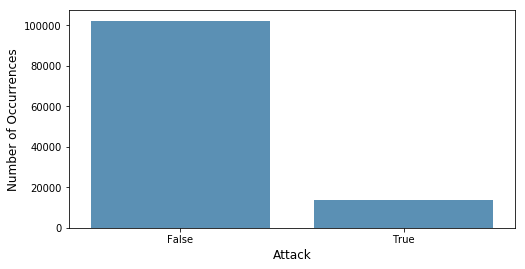

In [33]:
attack_level = comments['attack'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(attack_level.index, attack_level.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Attack', fontsize=12)
plt.show()

/Users/liangpengzhuang/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


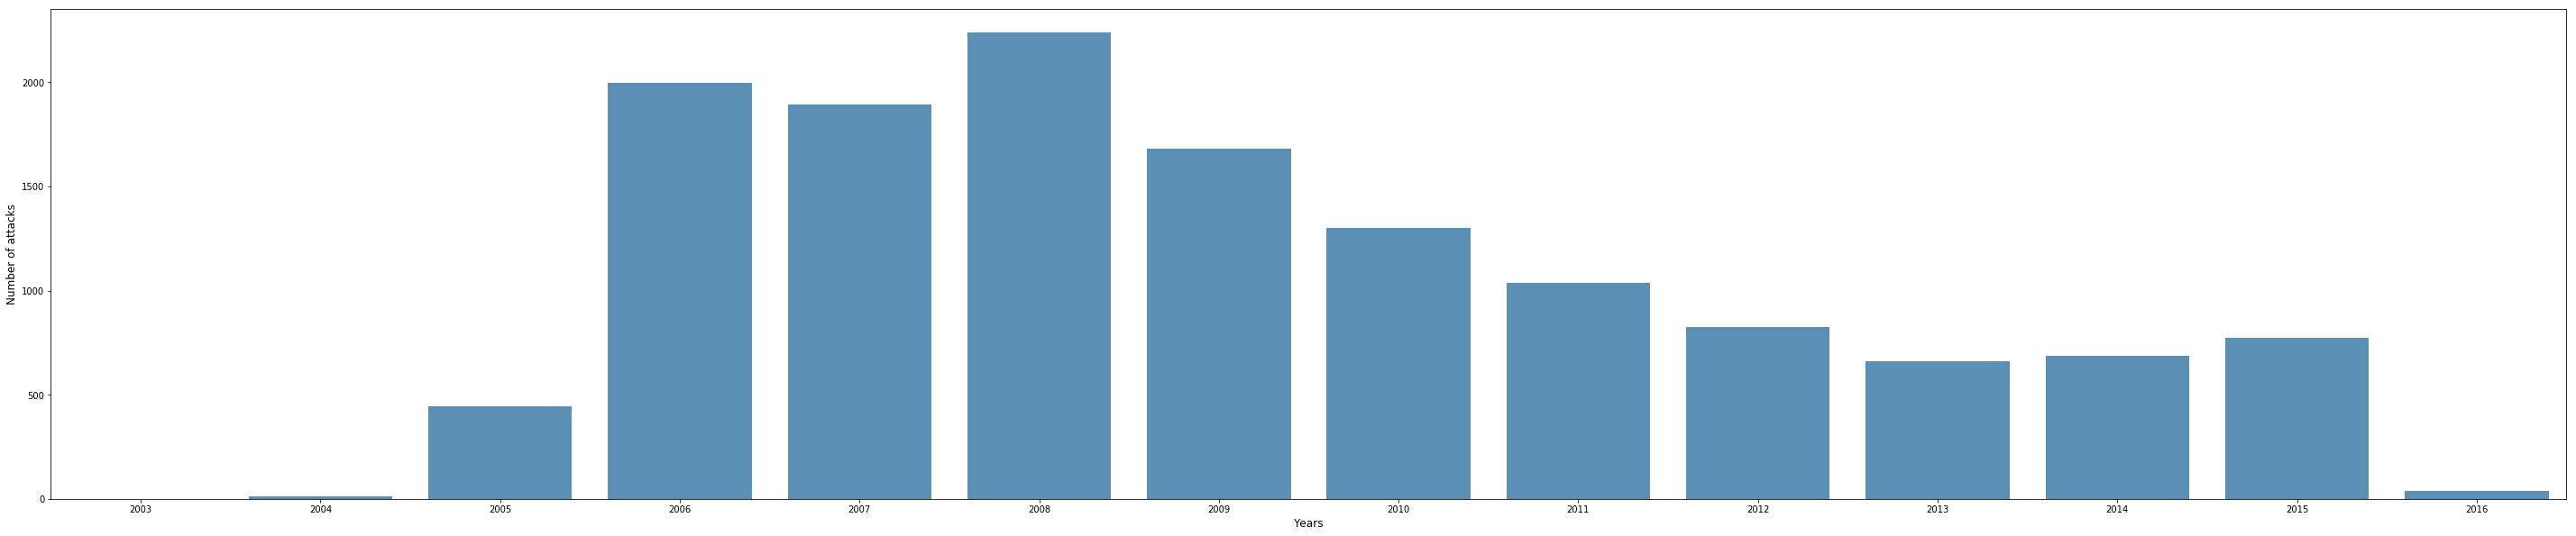

In [34]:
years = comments.query('attack').groupby('year').count()
years = years.attack
plt.figure(figsize=(50,10))
sns.barplot(years.index, years.values, alpha=0.8, color=color[0])
plt.ylabel('Number of attacks', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

## Train and Test Var
### Splits data into train, dev and tes

In [13]:
train_comments = comments.query("split=='train'")
dev_comments = comments.query("split=='dev'")
test_comments = comments.query("split=='test'")

In [14]:
# get rid of rev_id, year, logged_in, ns, sample column that will not be used in training
# only keep comments as training feature
def get_X_Y(data):
    X = data.comment
    Y = data.iloc[:, -1]
    return X, Y

### Prepare input and output vectors with corresbonding label

In [15]:
X_train, Y_train = get_X_Y(train_comments)
X_dev, Y_dev = get_X_Y(dev_comments)
X_test, Y_test = get_X_Y(test_comments)

In [10]:
X_train.sample(10)

rev_id
120378457    `NEWLINE_TOKENNEWLINE_TOKEN==Question==NEWLINE...
392551253    Daedalus is nothing but a filthy n!gger and a ...
270408448     look at joke pages relating to some random gu...
148443232    Just read the article, you will feel bad for b...
128368217    NEWLINE_TOKENNEWLINE_TOKENFUCK YOUR LIFE BITCH...
355693500    `NEWLINE_TOKENNEWLINE_TOKEN::::Hi,um, This is ...
172669718    NEWLINE_TOKENNEWLINE_TOKENyou gay motherfucker...
160733726    `NEWLINE_TOKENNEWLINE_TOKENThis not being fair...
149621805    NEWLINE_TOKENNEWLINE_TOKEN:: The criticism fro...
288272932    NEWLINE_TOKENNEWLINE_TOKEN== Whitehead group n...
Name: comment, dtype: object

## LogisticRegression

In [19]:
# fit a simple text classifier
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.965


In [40]:
# clf.get_params()

## MultinomialNB

In [41]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MultinomialNB()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.937


##  RandomForestClassifier

In [42]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', RandomForestClassifier()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.912


##  SVC

In [43]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LinearSVC()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [ ]:
# train_comments[:3]
test_comments[:3]

## MLPClassifier

In [44]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MLPClassifier()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

/Users/liangpengzhuang/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Test ROC AUC: 0.866


# Analysis

In [45]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False])

In [46]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([False])

In [47]:
from sklearn.metrics import confusion_matrix
y_val_pred = clf.predict_proba(test_comments['comment'])
y_val = test_comments.attack
log_loss(y_val, y_val_pred)

0.24709437797605946

In [48]:
preds = clf.predict(test_comments['comment'])

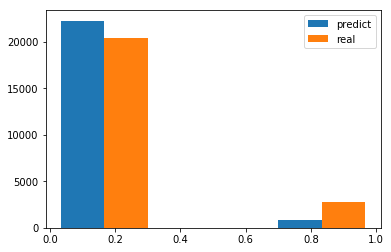

In [49]:
bins = np.linspace(0, 1, 4)
data = np.vstack([preds, y_val]).T
plt.hist(data, bins, alpha=1, label=['predict','real'])
plt.legend(loc='upper right')
plt.show()

In [50]:
from sklearn.metrics import classification_report

target_names = ['not_attack', 'attack']
print(classification_report(preds, y_val, target_names=target_names))

             precision    recall  f1-score   support

 not_attack       1.00      0.91      0.95     22290
     attack       0.31      0.97      0.47       888

avg / total       0.97      0.92      0.94     23178



In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, preds)

array([[20391,    31],
       [ 1899,   857]])

In [52]:
average_precision['micro']

NameError: name 'average_precision' is not defined

## CNN

In [6]:
import keras, os, pickle, re, sklearn, string, tensorflow
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.layers import Embedding
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

/Users/sizhewen/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Parameter

In [7]:
# EMBEDDING
MAX_NUM_WORDS  = 15000 # most comment number of words
EMBEDDING_DIM  = 300
MAX_SEQ_LENGTH = 200
USE_GLOVE      = True
USE_W2V        = False

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 1
VAL_SIZE       = 0.1

###  Tokenize comment string

In [36]:
# Clean comment string, and return a list of words
# Only consider character and number
def comment_to_wordlist(review, remove_stopwords=True):
    # Remove non-letters 
    review = re.sub("[^a-zA-Z ]"," ", review)
    words = review.lower().split()
    if remove_stopwords:
        words = [w for w in words if not w in stop_words]
    return words

In [37]:
def clean_text(comment):
    words = comment_to_wordlist(comment)
    return ' '.join(words)

### Text cleanning pipeline

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

def text_clean(text):
    tokens = word_tokenize(text)
#     tokens = re.split(r'\W+', text)
    tokens = [w.replace("NEWLINE_TOKEN", " ") for w in tokens]
    tokens = [w.replace("TAB_TOKEN", " ") for w in tokens]
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [w for w in tokens if w.isalpha()]
#     stop_words_list = set(stopwords.words('english'))
#     tokens = [w for w in tokens if w not in stop_words_list]
    filted_text = ' '.join(tokens)
    return filted_text
# comments['comment'] = comments['comment'].apply(text_clean)

In [12]:
% notify -m "clean"

X_train_clean = X_train.apply(text_clean)
X_test_clean = X_test.apply(text_clean)

<IPython.core.display.Javascript object>

NameError: name 'X_train' is not defined

In [10]:
% notify -m "clean"
X_train_clean.sample(3)

UsageError: Line magic function `%notify` not found.


In [17]:
X_test_clean.sample(3)

rev_id
453424686    real steel toys and video game is a real steel...
635619845    the entire wikipedia entry is the result of a ...
318001235    on a casual scan there are several punctuation...
Name: comment, dtype: object

In [16]:
docs = X_train.tolist()
test_docs = X_test.tolist()

In [17]:
def max_length(lines):
    """
    Calculate the maximum document length
    """
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(docs)
sequences = tokenizer.texts_to_sequences(docs)

length = max_length(docs)
word_index = tokenizer.word_index
result = [len(x.split()) for x in docs]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

Text informations:
max length: 2829 / min length: 1 / mean length: 68 / limit length: 200
vacobulary size: 138527 / limit: 15000


In [18]:
test_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
test_tokenizer.fit_on_texts(test_docs)
test_sequences = test_tokenizer.texts_to_sequences(test_docs)

test_length = max_length(test_docs)
test_word_index = tokenizer.word_index
test_result = [len(x.split()) for x in test_docs]

print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(test_result),
                                                                                np.min(test_result),
                                                                                np.mean(test_result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(test_word_index), MAX_NUM_WORDS))

Text informations:
max length: 2500 / min length: 1 / mean length: 69 / limit length: 200
vacobulary size: 138527 / limit: 15000


In [19]:
% notify -m "X , Y ready"

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
x_train = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
y_train = Y_train.tolist()
x_val = pad_sequences(test_sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
y_val = Y_test.tolist()

<IPython.core.display.Javascript object>

### Embeddings  
  
#### GloVe: Global Vectors for Word Representation
Please Refer: https://nlp.stanford.edu/projects/glove/

In [20]:
def create_glove_embeddings():
    print('Pretrained embeddings GloVe is loading...')

    embeddings_index = {}
    f = open('glove.6B.300d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors in GloVe embedding' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )

In [29]:
from gensim.models import word2vec

In [72]:
def create_w2v_embeddings():
    print('Pretrained embeddings w2v is loading...')
    
    model = word2vec.Word2Vec.load('w2v_model')
    embeddings_index = {}

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        if word in model.wv:
            embedding_vector = model.wv[word]
            embedding_matrix[i] = embedding_vector
        #if embedding_vector is not None:
            

    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     input_length=MAX_SEQ_LENGTH,
                     weights=[embedding_matrix],
                     trainable=True
                    )

In [83]:
label = Y_train.tolist()
len([x for x in y_val if x])

2756

In [22]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

69526
69526
23178
23178


### Training

In [23]:
import h5py

In [24]:
% notify -m "finish!"
import cnn_model

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))

    
    if USE_W2V:
        emb_layer = create_w2v_embeddings()
    elif USE_GLOVE:
        emb_layer = create_glove_embeddings()
    else:
        emb_layer = None
        
    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3),
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(x_val, y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    print()
    histories.append(history.history)

<IPython.core.display.Javascript object>

Running iteration 1/1
Pretrained embeddings GloVe is loading...
Found 400000 word vectors in GloVe embedding
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 15000
Embedding dim: 300
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 200
#############################################
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 69526 samples, validate on 23178 samples
Epoch 1/40
69526/69526 [==============================] - 362s 5ms/step - loss: 0.4409 - acc: 0.8968 - val_loss: 0.4040 - val_acc: 0.8743

Epoch 00001: val_loss improved from inf to 0.40401, saving model to model-1.h5
Epoch 2/40
69526/69526 [==============================] - 353s 5ms/step - loss: 0.2581 - acc: 0.9204 - val_loss: 0.4718 - val_acc: 0.8243

Epoch 00002: val_loss did not improve
Epoch 3/40
69526/69526 [==============================] - 355s 5ms/step - loss: 0.2364 - acc: 0.927

In [2]:
import nltk.data

ModuleNotFoundError: No module named 'nltk'

In [10]:
nltk.data.path = ['/Users/liangpengzhuang/Downloads/nltk_data']

In [25]:
with open('history.pkl', 'wb') as f:
    pickle.dump(histories, f)

In [26]:
histories = pickle.load(open('history.pkl', 'rb'))

In [27]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	0.4409 loss / 0.8968 acc
Validation: 	0.4040 loss / 0.8743 acc


In [28]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

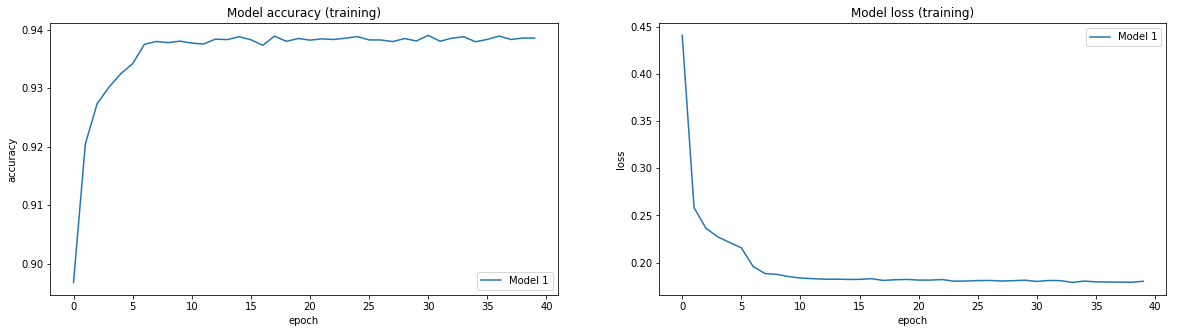

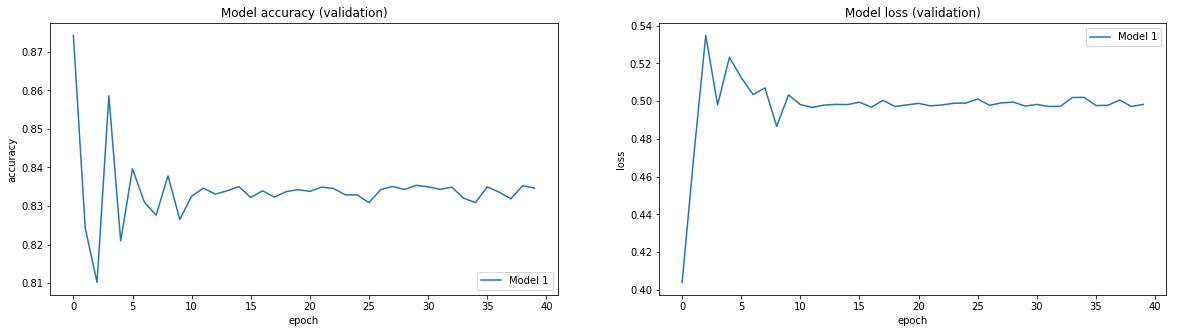

In [29]:

plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

In [30]:
sequences_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

In [32]:

test_loss = []
test_accs = []
test_labels = []
test_predicted = []

for i in range(0,RUNS):
    cnn_ = load_model("model-%i.h5" % (i+1))
    
    score = cnn_.evaluate(X_test, Y_test, verbose=1)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),
                                                                        np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

23178/23178 [==============================] - 52s 2ms/step
Running test with model 1: 0.2495 loss / 0.9216 acc

Average loss / accuracy on testset: 0.2495 loss / 0.9216 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc


In [86]:
def prob_to_label(Y_prob):
    result = []
    for prob in Y_prob:
        if prob >= 0.5:
            result.append(True)
        else:
            result.append(False)
    return np.asarray(result)

In [87]:
# y_prob = model.predict(x) 
# y_classes = y_prob.argmax(axis=-1)
# Y_predict 

for i in range(0, RUNS):
    cnn_ = load_model("model-%i.h5" % (i+1))
    Y_prob = cnn_.predict(X_test)
    Y_predict = prob_to_label(Y_prob)
    from sklearn import metrics
    print(metrics.classification_report(y_val, Y_predict))

             precision    recall  f1-score   support

      False       0.92      0.99      0.96     20422
       True       0.88      0.39      0.54      2756

avg / total       0.92      0.92      0.91     23178



In [85]:
Y_predict = prob_to_label(Y_prob)
len([x for x in Y_predict if x])


1230

In [76]:
from sklearn import metrics
print(metrics.classification_report(y_val, Y_predict))

             precision    recall  f1-score   support

      False       0.92      0.99      0.96     20422
       True       0.88      0.39      0.54      2756

avg / total       0.92      0.92      0.91     23178

